### Analysis using SARIMAX model for Time Series

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.dates as mdates
import warnings

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
# Ignoring warnings
warnings.filterwarnings("ignore")

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})
%matplotlib inline

#### Importing already collected data

In [4]:
df_daily = pd.read_csv("./datasets/proc/daily_variables.csv.zip", index_col = 0, parse_dates=["date"])
df_monthly = pd.read_csv("./datasets/proc/monthly_variables.csv.zip", index_col = 0, parse_dates=["date"])

#### Preprocessing for the analysis

In [5]:
# Scaling values
df_daily[df_daily.set_index('date').columns] = MinMaxScaler().fit_transform(df_daily[df_daily.set_index('date').columns])
df_monthly[df_monthly.set_index('date').columns] = MinMaxScaler().fit_transform(df_monthly[df_monthly.set_index('date').columns])

Bei der Analyse von Zeitreihen können durch Rauschen verursachte Oszillationen dazu führen, dass das Modell eine zu geringe Leistung aufweist. Um dieses Problem zu lösen, betrachten wir einen exponentiellen gleitenden Durchschnitt der analysierten Reihe, der die meisten der durch Rauschen verursachten Oszillationen eliminiert und uns hilft, unsere Analyse auf den Trend zu konzentrieren.

In [6]:
df_monthly[df_monthly.set_index('date').columns] = df_monthly.iloc[:,1:].ewm(span=40).mean()

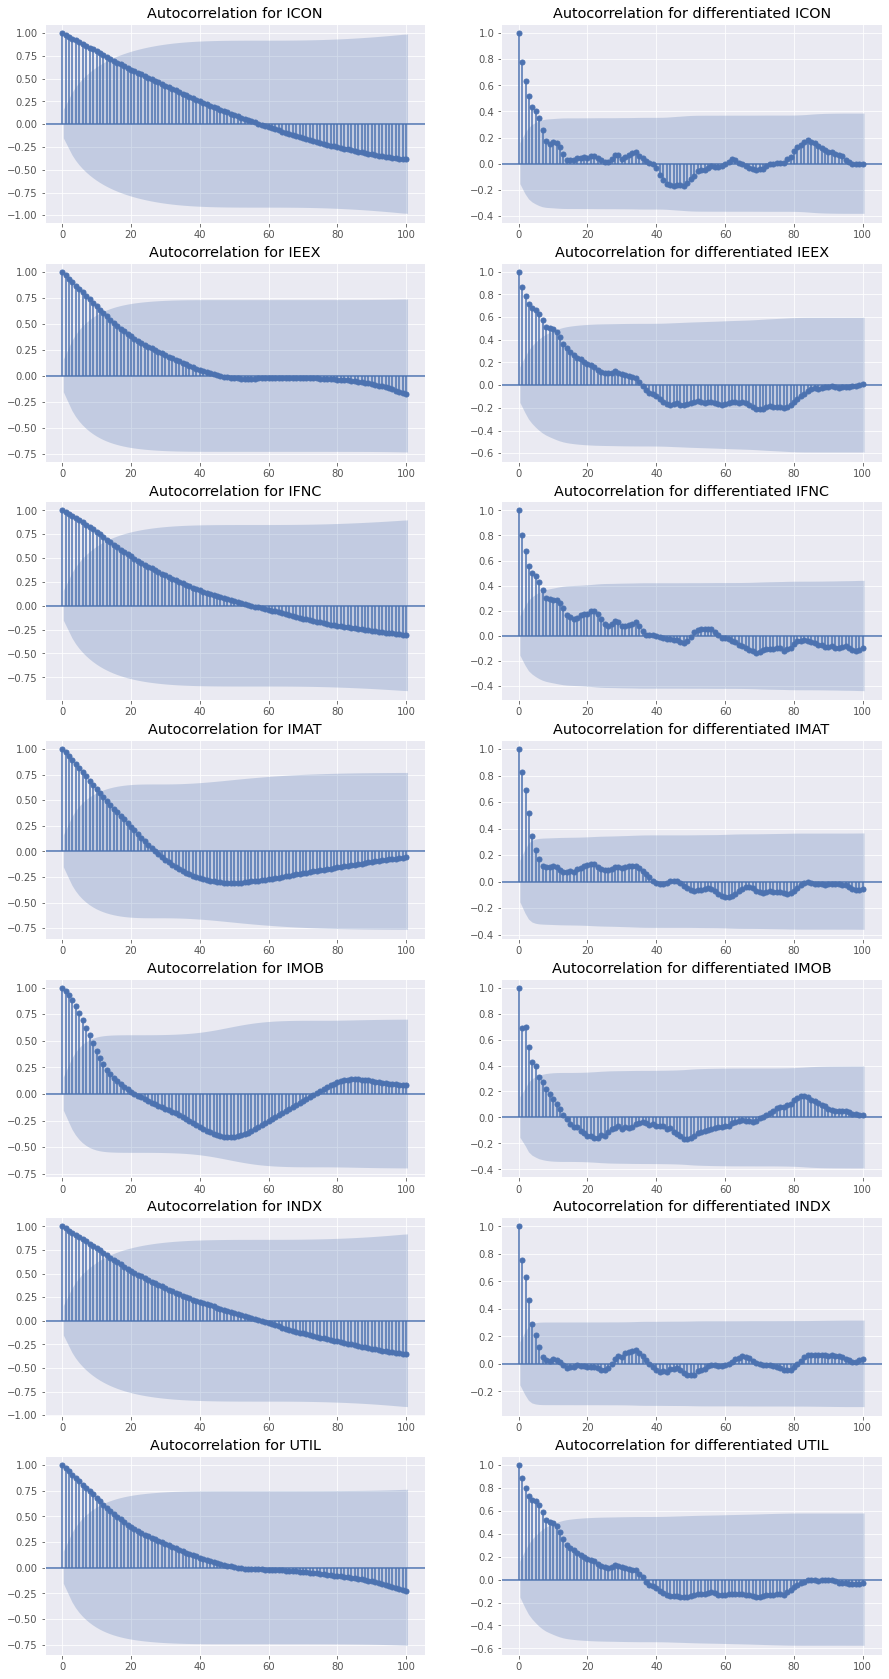

In [7]:
figure, axs = plt.subplots(7,2,figsize=(15,30))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    data = np.asarray(df_monthly[current_column])
    data_disl = data[1:]
    data_trunc = data[:-1]
    data_diff = data_disl - data_trunc
    plot_acf(data, lags=100, ax=axs[i,0], title=f"Autocorrelation for {current_column}")
    plot_acf(data_diff, lags=100, ax=axs[i,1], title=f"Autocorrelation for differentiated {current_column}")

plt.show()

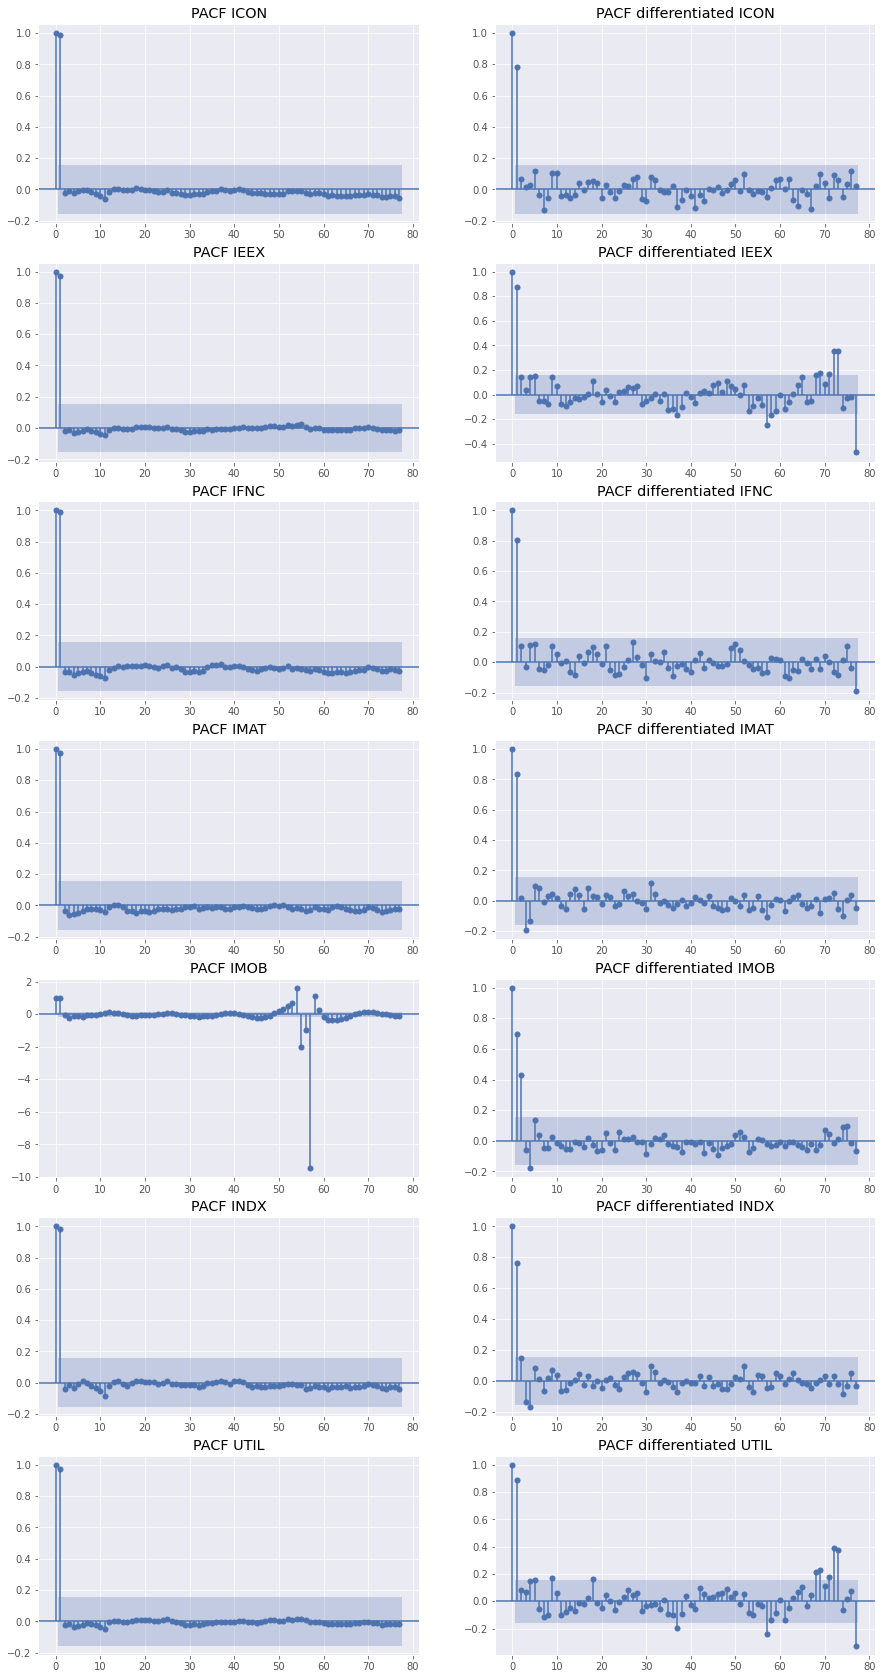

In [8]:
figure, axs = plt.subplots(7,2,figsize=(15,30))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    data = np.asarray(df_monthly[current_column])
    data_disl = data[1:]
    data_trunc = data[:-1]
    data_diff = data_disl - data_trunc
    plot_pacf(data, lags=77, ax=axs[i,0], title=f"PACF {current_column}")
    plot_pacf(data_diff, lags=77, ax=axs[i,1], title=f"PACF differentiated {current_column}")

plt.show()

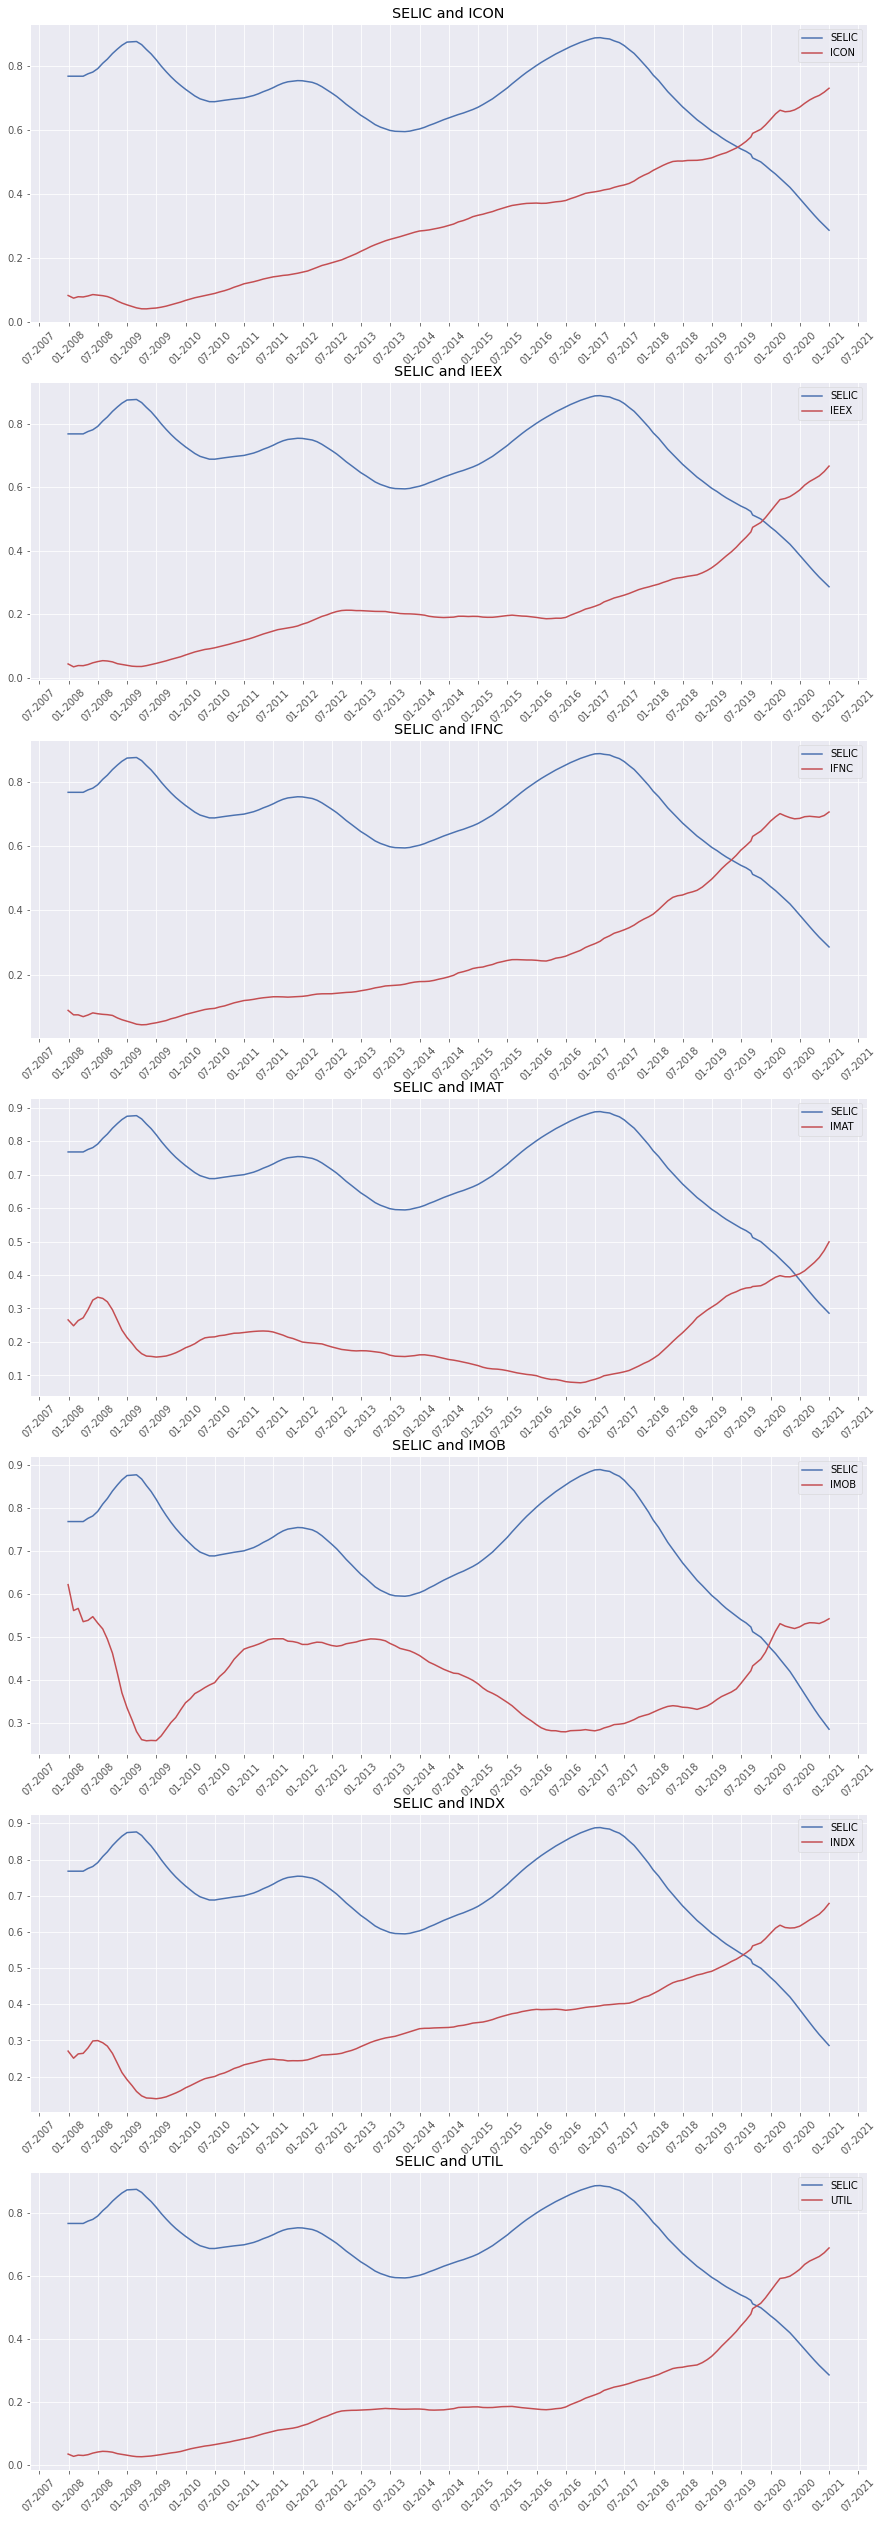

In [9]:
figure, axs = plt.subplots(7,1,figsize=(15,45))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    axs[i].plot(df_monthly["date"], df_monthly["SELIC"], label="SELIC")
    axs[i].plot(df_monthly["date"], df_monthly[current_column], label=f"{current_column}")
    axs[i].set_title(f"SELIC and {current_column}")
    axs[i].legend()
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
plt.show()

### Performing Time Series Analysis

### ICON

In [10]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["ICON"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -1117.3185594091922
                                      SARIMAX Results                                      
Dep. Variable:                                ICON   No. Observations:                  157
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                 694.648
Date:                             Sun, 04 Apr 2021   AIC                          -1369.295
Time:                                     10:53:18   BIC                          -1339.737
Sample:                                          0   HQIC                         -1357.284
                                             - 157                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.582e-06   2.71e-06      0.584 

### IEEX

In [11]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IEEX"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -1077.5412468044738
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.IEEX   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 683.738
Date:                            Sun, 04 Apr 2021   AIC                          -1351.476
Time:                                    10:56:25   BIC                          -1327.774
Sample:                                         0   HQIC                         -1341.845
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.316e-06   2.66e-06      1.249      0.2

### IFNC

In [12]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IFNC"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -1084.6518055914275
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.IFNC   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 659.929
Date:                            Sun, 04 Apr 2021   AIC                          -1303.857
Time:                                    10:57:05   BIC                          -1280.154
Sample:                                         0   HQIC                         -1294.225
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.511e-06   2.28e-06      0.662      0.5

### IMAT

In [13]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IMAT"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -1001.8880305960718
                                      SARIMAX Results                                      
Dep. Variable:                                IMAT   No. Observations:                  157
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                 611.847
Date:                             Sun, 04 Apr 2021   AIC                          -1201.695
Time:                                     10:59:29   BIC                          -1169.259
Sample:                                          0   HQIC                         -1188.514
                                             - 157                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        1.34e-06   6.29e-07      2.131 

### IMOB

In [14]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IMOB"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -882.64497296976577
                                      SARIMAX Results                                      
Dep. Variable:                         D.DS12.IMOB   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(0, 0, [], 12)   Log Likelihood                 553.956
Date:                             Sun, 04 Apr 2021   AIC                          -1087.912
Time:                                     11:00:25   BIC                          -1058.425
Sample:                                          0   HQIC                         -1075.929
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.257e-06   3.52e-06      0.357 

### INDX

In [15]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["INDX"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -585.89439127999457
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.INDX   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 632.958
Date:                            Sun, 04 Apr 2021   AIC                          -1247.916
Time:                                    11:01:13   BIC                          -1221.314
Sample:                                         0   HQIC                         -1237.106
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.257e-06   3.31e-06      1.587      0.1

### UTIL

In [16]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["UTIL"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    if result.aic < minAIC:
        print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -1053.8621755332722
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.UTIL   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 674.034
Date:                            Sun, 04 Apr 2021   AIC                          -1332.069
Time:                                    11:02:09   BIC                          -1308.366
Sample:                                         0   HQIC                         -1322.437
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       2.581e-06    2.8e-06      0.922      0.3